In [1]:
import sys
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
from scipy import interpolate
from PyAstronomy import pyasl
import matplotlib.pyplot as plt
from scipy import signal
import copy as cp
import pandas as pd
import pickle

In [54]:
def rearrange_time_series(obs_data, rv, times):
    """
    This function rearranges the RVs with the spectra.
    :param rv: list, the RVs
    :param times: list, the times
    """
    if len(times) < len(obs_data.time_series.times):
        print("Entering 1")
        print(len(times), len(obs_data.time_series.times), len(obs_data.time_series.vals), len(obs_data.time_series.calculated_vrad_list))
        ok_index = []
        for i,x in enumerate(obs_data.time_series.times):
            for j,y in enumerate(times):
                if abs(x-y)<1e-4:
                    ok_index.append(i)
        obs_data.time_series.times = [obs_data.time_series.times[i] for i in ok_index]
        obs_data.time_series.vals = [obs_data.time_series.vals[i] for i in ok_index]
        obs_data.air_mass = [obs_data.air_mass[i] for i in ok_index]
        obs_data.sample_size = len(obs_data.time_series.vals)
        obs_data.time_series.size = obs_data.sample_size
        obs_data.spec_list = obs_data.time_series.vals
        obs_data.time_series.calculated_vrad_list = rv
        print(len(obs_data.time_series.times), len(obs_data.time_series.vals), len(obs_data.time_series.calculated_vrad_list))
    # elif len(times) > len(obs_data.time_series.times):
    #     print("Entering 2")
    #     print(len(times), len(obs_data.time_series.times), len(obs_data.time_series.vals), len(obs_data.time_series.calculated_vrad_list))
    #     ok_index = []
    #     for i,x in enumerate(times):
    #         found = False
    #         for j,y in enumerate(obs_data.time_series.times):
    #             if abs(x-y)<1e-4:
    #                 found = True
    #                 break
    #             if not found:
    #                 ok_index.append(i)
    #     print(ok_index)
        # obs_data.time_series.times = [obs_data.time_series.times[i] for i in ok_index]
        # obs_data.time_series.vals = [obs_data.time_series.vals[i] for i in ok_index]
        # obs_data.air_mass = [obs_data.air_mass[i] for i in ok_index]
        # obs_data.sample_size = len(obs_data.time_series.vals)
        # obs_data.time_series.size = obs_data.sample_size
        # obs_data.spec_list = obs_data.time_series.vals
        # obs_data.time_series.calculated_vrad_list = rv
        # print(len(times), len(obs_data.time_series.times), len(obs_data.time_series.vals), len(obs_data.time_series.calculated_vrad_list))
        # ind_all = []
        # for index, t in enumerate(times):
        #     found = False
        #     for i in obs_data.time_series.times:
        #         if abs(i-t) < 1e-4:
        #             found = True
        #             break
        #     if not found:
        #         ind_all.append(index)
        # ok_index_all = [i for i, x in enumerate(times) if x <= max(obs_data.time_series.times)+1e-3]
        # ok_index_all = [i for i in ok_index_all if i not in ind_all]
        # times = [times[i] for i in ok_index_all]
        # rv = [rv[i] for i in ok_index_all]
        # obs_data.time_series.calculated_vrad_list = rv
    indices = []
    for obs in obs_data.time_series.times:
        indices.append(next(i for i, val in enumerate(times) if np.isclose(val, obs, atol=1e-4,
                                                                        rtol=0)))

    # Set the timeseries RV equal to the RV retrieved from starloader
    obs_data.time_series.calculated_vrad_list = rv[indices]
    obs_data.time_series.times = times[indices]

    print(len(obs_data.time_series.times), len(obs_data.time_series.vals), len(obs_data.time_series.calculated_vrad_list))

In [55]:
# PARAMETERS

survey = "CORALIE" # survey name
sample_rate = 1 # sample rate of the data
min_wv = 5600 # minimum wavelength of the data
max_wv = 5800 # maximum wavelength of the data
spec_dir = r"C:\Users\kentb\Desktop\PDM\thesis\main\S1D\BGCru" # directory of the spectra

rv_dir = r"C:\Users\kentb\Desktop\PDM\thesis\main\S1D\RV\BG_Cru_coralie14_all.csv" # directory of the RVs

freq_range = (1/5_0, 1/2) # frequency range of the periodograms
periodogram_grid_resolution = 11500 # frequency resolution of the periodograms
period_truth = [3.34] # true periods

results_dir = r"C:\Users\kentb\Desktop\PDM\thesis\main\S1D\results" # directory of the results

# Load the data

obs_data = Observations(survey=survey, sample_rate=sample_rate, min_wv=min_wv, max_wv=max_wv,
                        target_visits_lib=spec_dir)
df = pd.read_csv(rv_dir)
rv = df.rv.astype(float).values
e_rv = df.rv_err.astype(float).values
times = df.bjd.astype(float).values
times = times-int(min(times))

let's goooo
Using target_visits_lib: C:\Users\kentb\Desktop\PDM\thesis\main\S1D\BGCru
Selected directory: C:\Users\kentb\Desktop\PDM\thesis\main\S1D\BGCru


In [47]:
print(times[0],obs_data.time_series.times[0])

0.6325059999944642 0.6325060902163386


In [48]:
# Preprocess the spectra

for i in obs_data.time_series.vals:
    i = i.SpecPreProccess()


In [57]:
# Rearrange the RVs with the spectra

rearrange_time_series(obs_data=obs_data,rv=rv, times=times)

403 403 403
405


In [58]:
## Compute periodograms

# Choosing frequency range and frequency resolution for the periodograms.
obs_data.initialize_periodicity_detector(freq_range=freq_range,
                                         periodogram_grid_resolution=periodogram_grid_resolution)
obs_data.periodicity_detector.period_truth = period_truth

obs_data.periodicity_detector.calc_GLS()

is not float


(array([0.02      , 0.02008696, 0.02017391, ..., 0.49973913, 0.49982609,
        0.49991304]),
 array([1.41397866e-03, 4.59405034e-07, 1.16681734e-03, ...,
        9.57823143e-04, 1.06690735e-04, 6.79656230e-04]))

In [59]:
obs_data.periodicity_detector.calc_PDC(calc_biased_flag=False, calc_unbiased_flag=True)

obs_data.periodicity_detector.calc_USURPER(calc_biased_flag=False, calc_unbiased_flag=True)

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shape")

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shift")

In [61]:
# Save the observations instance in a pickle file with the name of the spec_dir name in the results directory
import os
file = open(results_dir+'\\'+spec_dir.split('\\')[-1]+'.pkl', "wb")
pickle.dump(obs_data, file)
file.close()

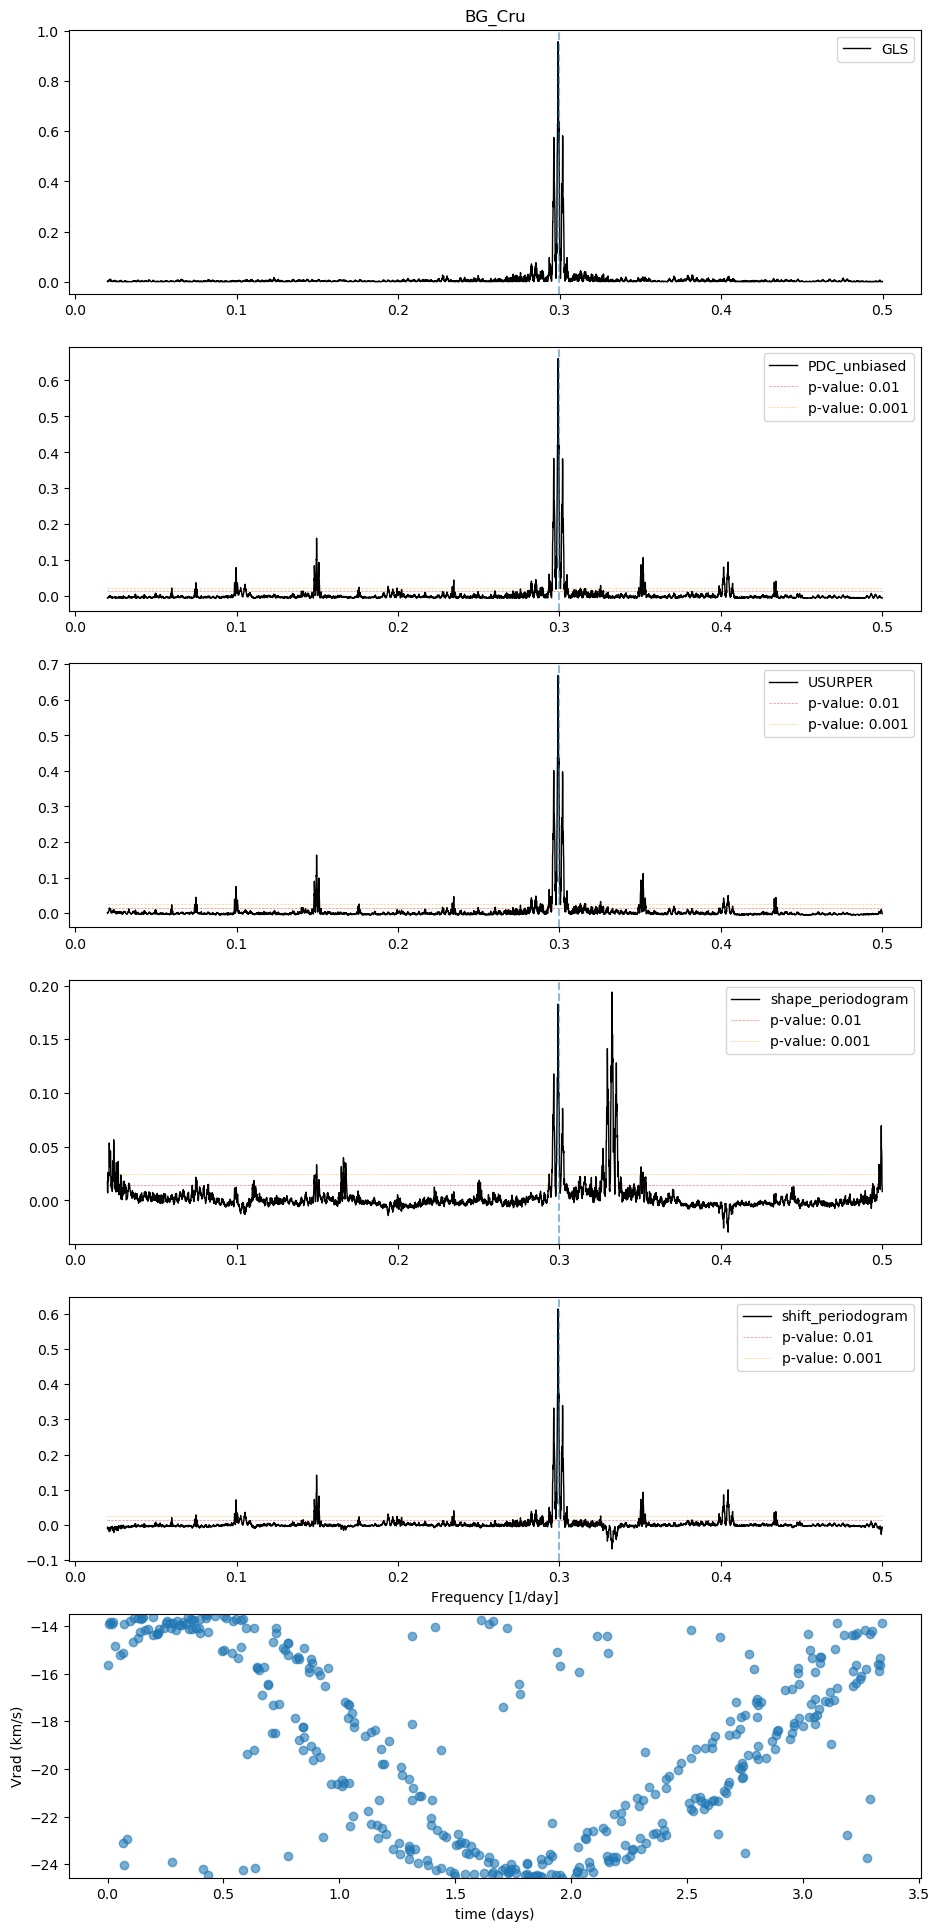

In [62]:
# plot the periodograms by opening the pickle file

file = open(results_dir+'\\'+spec_dir.split('\\')[-1]+'.pkl', "rb")
obs_data = pickle.load(file)
file.close()

obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-2,1e-3], plot_vals=True,title=r"BG_Cru")
plt.show()

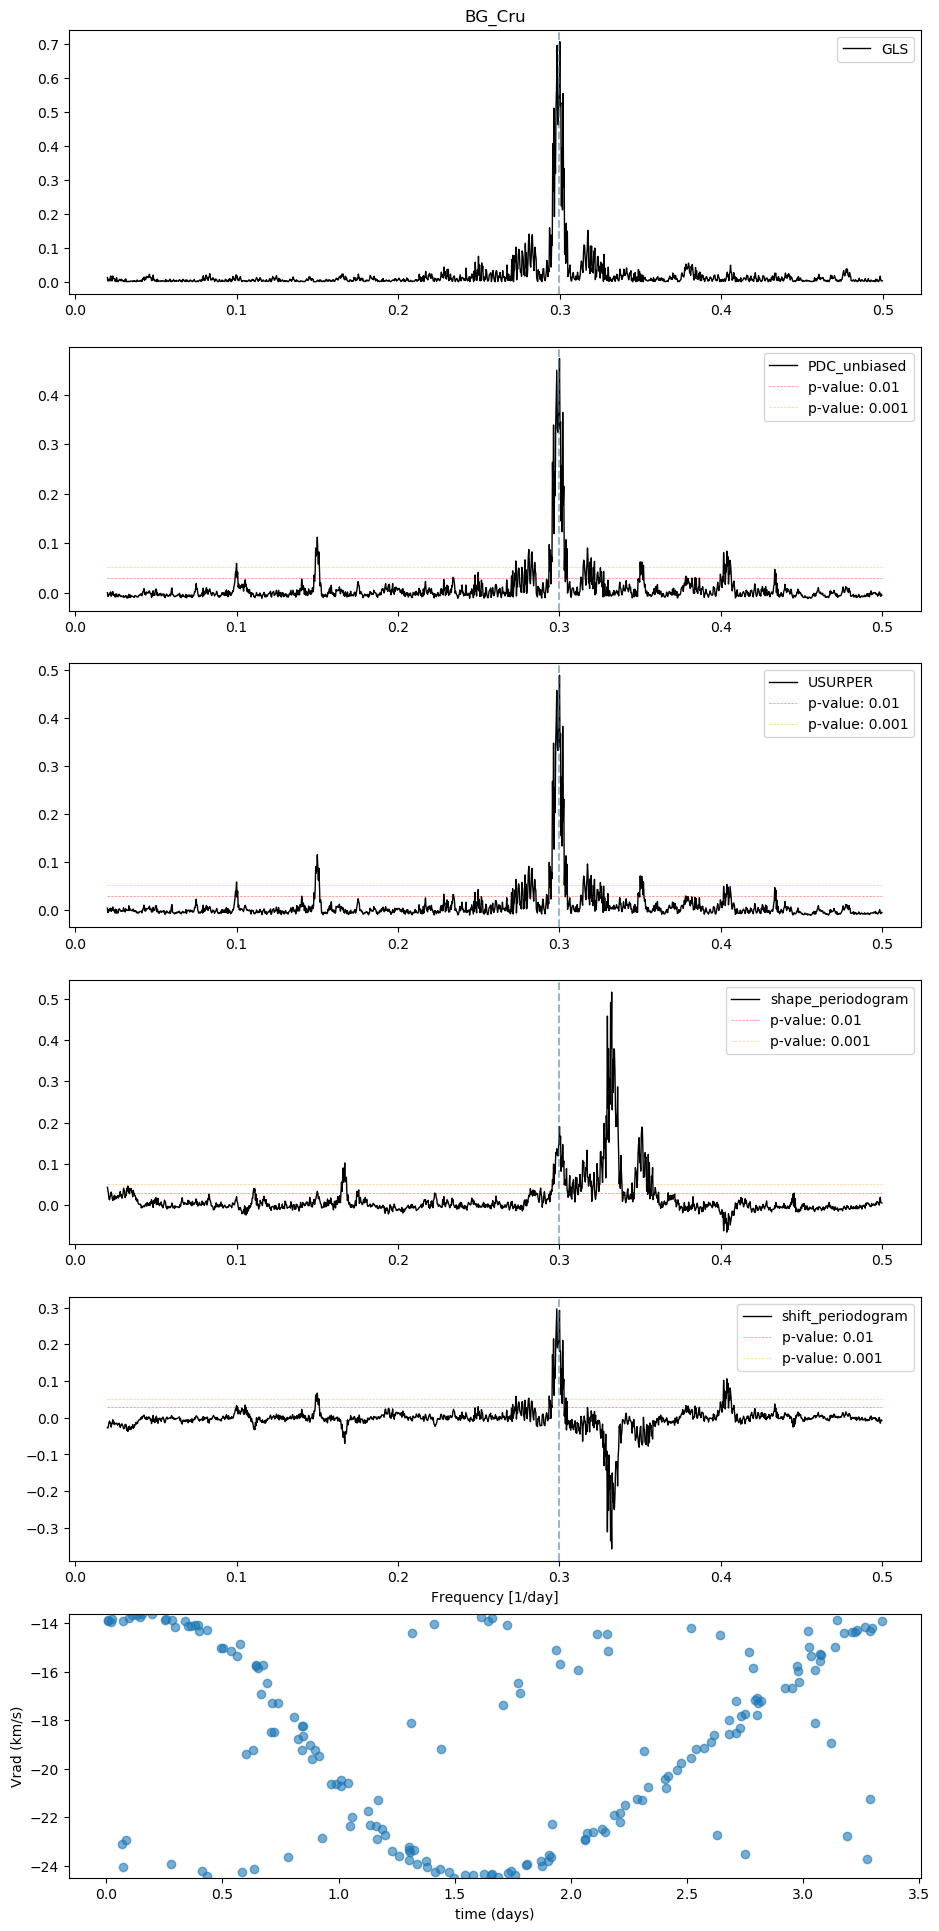

In [63]:
# plot the periodograms by opening the pickle file

file = open(results_dir+'\\'+spec_dir.split('\\')[-1]+'.pkl', "rb")
test = pickle.load(file)
file.close()

test.periodicity_detector.plot_periodograms(annotate_pval=[1e-2,1e-3], plot_vals=True,title=r"BG_Cru")
plt.show()